In [27]:
# =====================================
# SAFE GOOGLE DRIVE MOUNT (Colab)
# =====================================
import os
from google.colab import drive

# Step 1: Unmount if already mounted
try:
    drive.flush_and_unmount()
    print("✅ Drive unmounted (if it was mounted).")
except:
    print("ℹ️ No existing mount found, continuing...")

# Step 2: Clean mountpoint
!rm -rf /content/drive

# Step 3: Mount again
drive.mount('/content/drive', force_remount=True)

# Step 4: Verify dataset path
DATASET_PATH = "/content/drive/MyDrive/InfosysVirtual"
if os.path.exists(DATASET_PATH):
    print(f"✅ Dataset folder found at: {DATASET_PATH}")
else:
    print(f"⚠️ Dataset folder not found! Check if 'AI_Tracefinder' exists inside your MyDrive.")

✅ Drive unmounted (if it was mounted).
Mounted at /content/drive
✅ Dataset folder found at: /content/drive/MyDrive/InfosysVirtual


In [ ]:
import os, cv2, numpy as np, pickle
from tqdm import tqdm
import pywt
from concurrent.futures import ThreadPoolExecutor, as_completed

# Paths
OFFICIAL_DIR = "/content/drive/MyDrive/InfosysVirtual/Official"
WIKI_DIR = "/content/drive/MyDrive/InfosysVirtual/Wikipedia"
OUT_PATH = "/content/drive/MyDrive/InfosysVirtual/official_wiki_residuals.pkl"

# ---------------------------
# Preprocessing helpers
# ---------------------------
def to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img

def resize_to(img, size=(256,256)):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

def normalize_img(img):
    return img.astype(np.float32) / 255.0

def denoise_wavelet(img):
    coeffs = pywt.dwt2(img, 'haar')
    cA, (cH, cV, cD) = coeffs
    # Zero out detail coefficients for denoising
    cH[:] = 0; cV[:] = 0; cD[:] = 0
    return pywt.idwt2((cA,(cH,cV,cD)), 'haar')

def compute_residual(img):
    denoised = denoise_wavelet(img)
    return img - denoised

def process_single_image(fpath):
    """Preprocess one image and return residual"""
    img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    if img is None:
        return None
    gray = to_gray(img)
    gray = resize_to(gray, (256,256))
    gray = normalize_img(gray)
    return compute_residual(gray)

# ---------------------------
# Dataset Processing
# ---------------------------
def process_dataset(base_dir, dataset_name, residuals_dict):
    print(f"🔄 Preprocessing {dataset_name} images...")

    for scanner in tqdm(os.listdir(base_dir)):
        scanner_path = os.path.join(base_dir, scanner)
        if not os.path.isdir(scanner_path):
            continue

        residuals_dict[dataset_name][scanner] = {}

        for dpi in os.listdir(scanner_path):   # 150, 300
            dpi_path = os.path.join(scanner_path, dpi)
            if not os.path.isdir(dpi_path):
                continue

            files = [os.path.join(dpi_path, f) for f in os.listdir(dpi_path)
                     if f.lower().endswith(('.tif','.tiff','.jpg','.jpeg','.png'))]

            dpi_residuals = []
            # Parallel processing
            with ThreadPoolExecutor(max_workers=8) as executor:  # adjust workers based on Colab
                futures = [executor.submit(process_single_image, f) for f in files]
                for fut in as_completed(futures):
                    res = fut.result()
                    if res is not None:
                        dpi_residuals.append(res)

            residuals_dict[dataset_name][scanner][dpi] = dpi_residuals

# ---------------------------
# Main Execution
# ---------------------------
residuals_dict = {"Official": {}, "Wikipedia": {}}

process_dataset(OFFICIAL_DIR, "Official", residuals_dict)
process_dataset(WIKI_DIR, "Wikipedia", residuals_dict)

with open(OUT_PATH, "wb") as f:
    pickle.dump(residuals_dict, f)

print(f"✅ Saved Official+Wiki residuals (150 & 300 separately) to {OUT_PATH}")

🔄 Preprocessing Official images...


100%|██████████| 11/11 [02:23<00:00, 13.03s/it]


🔄 Preprocessing Wikipedia images...


100%|██████████| 11/11 [01:41<00:00,  9.27s/it]


✅ Saved Official+Wiki residuals (150 & 300 separately) to /content/drive/MyDrive/InfosysVirtual/official_wiki_residuals.pkl


In [ ]:
# ---------------------------
# 0) Mount Google Drive
# ---------------------------
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

import os, pickle, cv2, numpy as np
from tqdm import tqdm

# ---------------------------
# 1) Auto-locate Flatfield folder
# ---------------------------
def find_flatfield(base="/content/drive/MyDrive/InfosysVirtual"):
    found = []
    for root, dirs, files in os.walk(base):
        for d in dirs:
            if d.lower() == "flatfield":   # case-insensitive match
                found.append(os.path.join(root, d))
    return found

flatfield_paths = find_flatfield("/content/drive/MyDrive/InfosysVirtual")
if not flatfield_paths:
    raise FileNotFoundError("❌ No 'Flatfield' folder found. Please check your Drive.")
else:
    FLATFIELD_DIR = flatfield_paths[0]
    BASE = os.path.dirname(FLATFIELD_DIR)
    OUTPUT_PKL = os.path.join(BASE, "flatfield_residuals.pkl")
    print("✅ Found Flatfield folder:", FLATFIELD_DIR)
    print("📦 Will save residuals to:", OUTPUT_PKL)

# ---------------------------
# 2) Import denoising filters
# ---------------------------
try:
    from skimage.restoration import denoise_wavelet
except ImportError:
    !pip install scikit-image
    from skimage.restoration import denoise_wavelet

from scipy.signal import wiener as scipy_wiener

# ---------------------------
# 3) Parameters
# ---------------------------
IMG_SIZE = (256, 256)         # Resize target
DENOISE_METHOD = "wavelet"    # Options: "wiener" or "wavelet"

# ---------------------------
# 4) Preprocessing function
# ---------------------------
def preprocess_image_residual(path, img_size=IMG_SIZE, method="wiener"):
    """Read → Grayscale → Resize → Normalize → Denoise → Residual"""
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        return None
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0

    if method == "wiener":
        den = scipy_wiener(img, mysize=(5, 5))
    else:
        den = denoise_wavelet(img, channel_axis=None, rescale_sigma=True)

    return (img - den).astype(np.float32)

# ---------------------------
# 5) Process all Flatfield images
# ---------------------------
flatfield_residuals = {}
scanners = sorted(os.listdir(FLATFIELD_DIR))

for scanner in tqdm(scanners, desc="📂 Scanners"):
    scanner_dir = os.path.join(FLATFIELD_DIR, scanner)
    if not os.path.isdir(scanner_dir):
        continue

    residuals = []
    for fname in sorted(os.listdir(scanner_dir)):
        if fname.startswith("._") or not fname.lower().endswith((".tif", ".tiff", ".png", ".jpg", ".jpeg")):
            continue
        fpath = os.path.join(scanner_dir, fname)
        try:
            res = preprocess_image_residual(fpath, IMG_SIZE, DENOISE_METHOD)
            if res is not None:
                residuals.append(res)
        except Exception as e:
            print(f"⚠️ Failed on {fpath}: {e}")

    if residuals:
        flatfield_residuals[scanner] = residuals
    else:
        print(f"⚠️ No valid images for scanner: {scanner}")

# ---------------------------
# 6) Save residuals dictionary
# ---------------------------
with open(OUTPUT_PKL, "wb") as f:
    pickle.dump(flatfield_residuals, f)

# ---------------------------
# 7) Summary
# ---------------------------
total_scanners = len(flatfield_residuals)
total_images = sum(len(v) for v in flatfield_residuals.values())
print(f"\n✅ Done. Saved residuals for {total_scanners} scanners, {total_images} images.")
print("🔍 Example scanners:", list(flatfield_residuals.keys())[:5])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Found Flatfield folder: /content/drive/MyDrive/InfosysVirtual/Flatfield
📦 Will save residuals to: /content/drive/MyDrive/InfosysVirtual/flatfield_residuals.pkl


📂 Scanners: 100%|██████████| 11/11 [00:55<00:00,  5.03s/it]


✅ Done. Saved residuals for 11 scanners, 22 images.
🔍 Example scanners: ['Canon120-1', 'Canon120-2', 'Canon220', 'Canon9000-1', 'Canon9000-2']


In [ ]:
import os
from tabulate import tabulate
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

def count_images_tif(dataset_path, extensions=None):
    if extensions is None:
        # Include .tif images
        extensions = {".tif"}

    class_counts = {}
    total_images = 0

    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            subfolder_counts = {}
            class_total = 0
            # Walk recursively through all subfolders
            for root, dirs, files in os.walk(class_path):
                sub_count = sum(1 for f in files if os.path.splitext(f)[1].lower() in extensions)
                subfolder_name = os.path.relpath(root, dataset_path)
                subfolder_counts[subfolder_name] = sub_count
                class_total += sub_count

            # Print table for this class
            print(f"\nClass: {class_name}")
            table = [[sub, cnt] for sub, cnt in subfolder_counts.items()]
            print(tabulate(table, headers=["Subfolder", "Number of Images"], tablefmt="grid"))
            print(f"Total images in class '{class_name}': {class_total}\n")

            class_counts[class_name] = class_total
            total_images += class_total

    print(f"Total images in dataset: {total_images}")
    return class_counts, total_images

# Set your dataset path
dataset_path = "/content/drive/MyDrive/InfosysVirtual"
count_images_tif(dataset_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Class: Tampered images
+--------------------------------------------------+--------------------+
| Subfolder                                        |   Number of Images |
+==================================================+====================+
| Tampered images                                  |                  0 |
+--------------------------------------------------+--------------------+
| Tampered images/Description                      |                  0 |
+--------------------------------------------------+--------------------+
| Tampered images/Binary masks                     |                  0 |
+--------------------------------------------------+--------------------+
| Tampered images/Binary masks/Splicing            |                 31 |
+--------------------------------------------------+--------------------+
| Tampered images/Binary masks/Re

({'Tampered images': 102,
  'Flatfield': 23,
  'Official': 322,
  'Wikipedia': 226,
  'Official_Features': 0,
  'Wikipedia_Features': 0,
  'Flatfield_Features': 0,
  'models': 0},
 673)

In [ ]:
import os
import cv2
from google.colab import drive


# Paths
dataset_path = "/content/drive/MyDrive/InfosysVirtual"
extensions = {".tif"}

corrupted_files = []

# Walk through entire dataset
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if os.path.splitext(file)[1].lower() in extensions:
            file_path = os.path.join(root, file)
            img = cv2.imread(file_path)
            if img is None:
                corrupted_files.append(file_path)

# Print summary
print(f"Total corrupted files found: {len(corrupted_files)}")
if len(corrupted_files) > 0:
    for f in corrupted_files:
        print(f)
else:
    print("No corrupted images found!")

Total corrupted files found: 1
/content/drive/MyDrive/InfosysVirtual/Flatfield/EpsonV39-1/._150.tif


In [ ]:
import pickle, numpy as np
import os

# ---------------------------
# Dynamic Path Setup
# ---------------------------
FLATFIELD_DIR = "/content/drive/MyDrive/InfosysVirtual/Flatfield"
BASE_DIR = os.path.dirname(FLATFIELD_DIR)

FLATFIELD_RESIDUALS_PATH = os.path.join(BASE_DIR, "flatfield_residuals.pkl")
FP_OUT_PATH = os.path.join(BASE_DIR, "scanner_fingerprints.pkl")
ORDER_NPY = os.path.join(BASE_DIR, "fp_keys.npy")

# ---------------------------
# Load residuals
# ---------------------------
with open(FLATFIELD_RESIDUALS_PATH, "rb") as f:
    flatfield_residuals = pickle.load(f)

# ---------------------------
# Compute fingerprint per scanner
# ---------------------------
scanner_fingerprints = {}
print("🔄 Computing fingerprints from Flatfields...")
for scanner, residuals in flatfield_residuals.items():
    if not residuals:
        continue
    stack = np.stack(residuals, axis=0)       # (num_images, H, W)
    fingerprint = np.mean(stack, axis=0)      # average residual
    scanner_fingerprints[scanner] = fingerprint

print(f"✅ Extracted {len(scanner_fingerprints)} scanner fingerprints.")

# ---------------------------
# Save fingerprints
# ---------------------------
with open(FP_OUT_PATH, "wb") as f:
    pickle.dump(scanner_fingerprints, f)
print(f"📦 Saved scanner fingerprints to: {FP_OUT_PATH}")

# ---------------------------
# Save a stable, deterministic order for scanners
# ---------------------------
fp_keys = sorted(scanner_fingerprints.keys())
np.save(ORDER_NPY, np.array(fp_keys))
print("📑 Saved fp_keys.npy with order:", fp_keys)


🔄 Computing fingerprints from Flatfields...
✅ Extracted 11 scanner fingerprints.
📦 Saved scanner fingerprints to: /content/drive/MyDrive/InfosysVirtual/scanner_fingerprints.pkl
📑 Saved fp_keys.npy with order: ['Canon120-1', 'Canon120-2', 'Canon220', 'Canon9000-1', 'Canon9000-2', 'EpsonV370-1', 'EpsonV370-2', 'EpsonV39-1', 'EpsonV39-2', 'EpsonV550', 'HP']


In [ ]:
import pickle, numpy as np
from tqdm import tqdm

# Paths
RES_PATH   = "/content/drive/MyDrive/InfosysVirtual/official_wiki_residuals.pkl"
FP_PATH    = "/content/drive/MyDrive/InfosysVirtual/scanner_fingerprints.pkl"
ORDER_NPY  = "/content/drive/MyDrive/InfosysVirtual/fp_keys.npy"
OUT_PATH   = "/content/drive/MyDrive/InfosysVirtual/features.pkl"

# Load fingerprints and fixed order
with open(FP_PATH, "rb") as f:
    scanner_fps = pickle.load(f)
fp_keys = np.load(ORDER_NPY, allow_pickle=True).tolist()
print("✅ Loaded fingerprints and key order. Keys:", fp_keys)

# Helper: normalized cross-correlation (zero-mean cosine similarity)
def corr2d(a, b):
    a = a.astype(np.float32).ravel()
    b = b.astype(np.float32).ravel()
    a -= a.mean()
    b -= b.mean()
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return float((a @ b) / denom) if denom != 0 else 0.0
# ZNCC equals the dot product of zero-mean, unit-norm vectors, i.e., cosine similarity in L2 space. [web:188][web:189][web:169]

# Load residuals (already precomputed; do not preprocess again)
with open(RES_PATH, "rb") as f:
    residuals_dict = pickle.load(f)
print("✅ Loaded residuals for datasets:", list(residuals_dict.keys()))

# Build features in the exact fp_keys order
features, labels = [], []
for dataset_name in ["Official", "Wikipedia"]:
    print(f"🔄 Computing features for {dataset_name} ...")
    for scanner, dpi_dict in tqdm(residuals_dict[dataset_name].items()):
        for dpi, res_list in dpi_dict.items():
            for res in res_list:
                vec = [corr2d(res, scanner_fps[k]) for k in fp_keys]
                features.append(vec)
                labels.append(scanner)

# Save features + labels
with open(OUT_PATH, "wb") as f:
    pickle.dump({"features": features, "labels": labels}, f)
print(f"✅ Saved features + labels to {OUT_PATH}")
print("Shape:", (len(features), len(features[0]) if features else 0))

✅ Loaded fingerprints and key order. Keys: ['Canon120-1', 'Canon120-2', 'Canon220', 'Canon9000-1', 'Canon9000-2', 'EpsonV370-1', 'EpsonV370-2', 'EpsonV39-1', 'EpsonV39-2', 'EpsonV550', 'HP']
✅ Loaded residuals for datasets: ['Official', 'Wikipedia']
🔄 Computing features for Official ...


100%|██████████| 11/11 [00:01<00:00, 10.89it/s]


🔄 Computing features for Wikipedia ...


100%|██████████| 11/11 [00:00<00:00, 23.50it/s]

✅ Saved features + labels to /content/drive/MyDrive/InfosysVirtual/features.pkl
Shape: (548, 11)


In [ ]:
# ==============================
# Enhanced Feature Extraction (FFT + LBP + Texture)
# ==============================
import pickle, numpy as np, os
from tqdm import tqdm
from skimage.feature import local_binary_pattern
from scipy import ndimage
from scipy.fft import fft2, fftshift
import matplotlib.pyplot as plt

# ---------------------------
# Path Setup
# ---------------------------
BASE_DIR = "/content/drive/MyDrive/InfosysVirtual"
RES_PATH = os.path.join(BASE_DIR, "official_wiki_residuals.pkl")
ENHANCED_OUT = os.path.join(BASE_DIR, "enhanced_features.pkl")

# ---------------------------
# Load residuals
# ---------------------------
with open(RES_PATH, "rb") as f:
    residuals_dict = pickle.load(f)

# ---------------------------
# Feature Extraction Function
# ---------------------------
def extract_enhanced_features(residual):
    """Extract FFT + LBP + Texture features from a residual image"""

    # 1. FFT Features
    fft_img = np.abs(fft2(residual))
    fft_img = fftshift(fft_img)

    h, w = fft_img.shape
    center_h, center_w = h // 2, w // 2

    low_freq = np.mean(fft_img[center_h-20:center_h+20, center_w-20:center_w+20])
    mid_freq = np.mean(fft_img[center_h-60:center_h+60, center_w-60:center_w+60]) - low_freq
    high_freq = np.mean(fft_img) - low_freq - mid_freq

    # 2. LBP Features (cast to uint8 to avoid warnings)
    lbp = local_binary_pattern((residual * 255).astype(np.uint8), P=24, R=3, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=26, range=(0, 25), density=True)

    # 3. Texture Features
    grad_x = ndimage.sobel(residual, axis=1)
    grad_y = ndimage.sobel(residual, axis=0)
    gradient_mag = np.sqrt(grad_x**2 + grad_y**2)

    texture_features = [
        np.std(residual),
        np.mean(np.abs(residual)),
        np.std(gradient_mag),
        np.mean(gradient_mag),
    ]

    return [low_freq, mid_freq, high_freq] + lbp_hist.tolist() + texture_features

# ---------------------------
# Extract Features
# ---------------------------
print("🔄 Extracting enhanced features (FFT + LBP + Texture)...")
enhanced_features, enhanced_labels = [], []

for dataset_name in ["Official", "Wikipedia"]:
    print(f"📁 Processing {dataset_name}...")
    for scanner, dpi_dict in tqdm(residuals_dict[dataset_name].items()):
        for dpi, res_list in dpi_dict.items():
            for res in res_list:
                feat = extract_enhanced_features(res)
                enhanced_features.append(feat)
                enhanced_labels.append(scanner)

# ---------------------------
# Save Features
# ---------------------------
with open(ENHANCED_OUT, "wb") as f:
    pickle.dump({"features": enhanced_features, "labels": enhanced_labels}, f)

# ---------------------------
# Summary
# ---------------------------
print(f"\n✅ Enhanced features shape: {len(enhanced_features)} x {len(enhanced_features[0])}")
print(f"📦 Saved to: {ENHANCED_OUT}")


🔄 Extracting enhanced features (FFT + LBP + Texture)...
📁 Processing Official...


100%|██████████| 11/11 [00:18<00:00,  1.72s/it]


📁 Processing Wikipedia...


100%|██████████| 11/11 [00:10<00:00,  1.03it/s]


✅ Enhanced features shape: 548 x 33
📦 Saved to: /content/drive/MyDrive/InfosysVirtual/enhanced_features.pkl


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:39:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ XGBoost Accuracy: 75.45%

✅ Classification Report:
              precision    recall  f1-score   support

  Canon120-1       0.33      0.25      0.29         4
  Canon120-2       0.52      0.69      0.59        16
    Canon220       1.00      0.38      0.55         8
 Canon9000-1       0.81      1.00      0.90        22
 Canon9000-2       0.86      0.50      0.63        12
 EpsonV370-1       0.94      0.94      0.94        18
 EpsonV370-2       0.78      0.88      0.82         8
  EpsonV39-1       0.65      0.92      0.76        12
  EpsonV39-2       1.00      0.25      0.40         4
   EpsonV550       1.00      0.50      0.67         4
          HP       1.00      1.00      1.00         2

    accuracy                           0.75       110
   macro avg       0.81      0.66      0.69       110
weighted avg       0.79      0.75      0.74       110



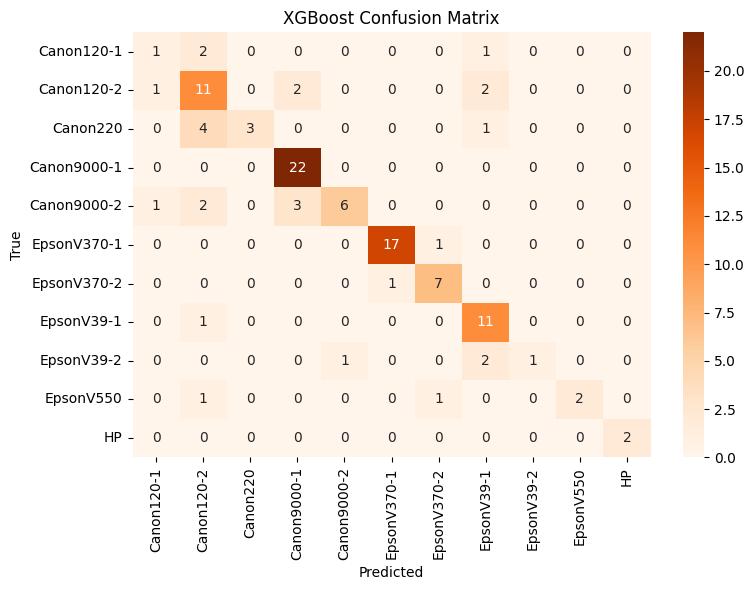

In [ ]:
# ==============================
# XGBoost on Handcrafted Features
# ==============================
import os, pickle, numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import local_binary_pattern as sk_lbp

# ---- Paths ----
BASE_DIR  = "/content/drive/MyDrive/InfosysVirtual"
RES_PATH  = os.path.join(BASE_DIR, "official_wiki_residuals.pkl")
FP_PATH   = os.path.join(BASE_DIR, "scanner_fingerprints.pkl")
ORDER_NPY = os.path.join(BASE_DIR, "fp_keys.npy")
ART_DIR   = BASE_DIR
os.makedirs(ART_DIR, exist_ok=True)

# ---- Load Data ----
with open(RES_PATH, "rb") as f:
    residuals_dict = pickle.load(f)
with open(FP_PATH, "rb") as f:
    scanner_fps = pickle.load(f)
fp_keys = np.load(ORDER_NPY, allow_pickle=True).tolist()

# ---- Feature Utilities ----
def corr2d(a, b):
    a = a.astype(np.float32).ravel(); b = b.astype(np.float32).ravel()
    a -= a.mean(); b -= b.mean()
    d = np.linalg.norm(a)*np.linalg.norm(b)
    return float((a @ b) / d) if d != 0 else 0.0

def fft_radial_energy(img, K=6):
    f = np.fft.fftshift(np.fft.fft2(img))
    mag = np.abs(f)
    h, w = mag.shape; cy, cx = h//2, w//2
    yy, xx = np.ogrid[:h, :w]
    r = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    rmax = r.max() + 1e-6
    bins = np.linspace(0, rmax, K+1)
    feats = [float(np.mean(mag[(r >= bins[i]) & (r < bins[i+1])])) for i in range(K)]
    return feats

def lbp_hist_safe(img, P=8, R=1.0):
    rng = float(np.ptp(img))
    g = np.zeros_like(img, dtype=np.float32) if rng < 1e-12 else (img - float(np.min(img))) / (rng + 1e-8)
    g8 = (g * 255.0).astype(np.uint8)
    codes = sk_lbp(g8, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
    return hist.astype(np.float32).tolist()

# ---- Build Feature Dataset ----
X_feat, y = [], []
for dataset_name in ["Official", "Wikipedia"]:
    for scanner, dpi_dict in residuals_dict[dataset_name].items():
        for dpi, res_list in dpi_dict.items():
            for res in res_list:
                v_corr = [corr2d(res, scanner_fps[k]) for k in fp_keys]
                v_fft  = fft_radial_energy(res, K=6)
                v_lbp  = lbp_hist_safe(res, P=8, R=1.0)
                X_feat.append(v_corr + v_fft + v_lbp)
                y.append(scanner)

X_feat = np.array(X_feat, dtype=np.float32)
y      = np.array(y)

# ---- Encode Labels ----
le = LabelEncoder()
y_int = le.fit_transform(y)

# ---- Train/Test Split ----
X_tr, X_te, y_tr, y_te = train_test_split(X_feat, y_int, test_size=0.2, random_state=42, stratify=y_int)

# ---- Scale Features ----
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_te = scaler.transform(X_te)

# ---- Train XGBoost ----
xgb = XGBClassifier(n_estimators=300, max_depth=8, learning_rate=0.1,
                    subsample=0.8, colsample_bytree=0.8, use_label_encoder=False,
                    eval_metric='mlogloss', random_state=42)
xgb.fit(X_tr, y_tr)

# ---- Save Model & Scaler ----
with open(os.path.join(ART_DIR, "xgb_model.pkl"), "wb") as f:
    pickle.dump(xgb, f)
with open(os.path.join(ART_DIR, "xgb_scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)
with open(os.path.join(ART_DIR, "xgb_label_encoder.pkl"), "wb") as f:
    pickle.dump(le, f)

# ---- Evaluate ----
y_pred = xgb.predict(X_te)
acc = accuracy_score(y_te, y_pred)
print(f"\n✅ XGBoost Accuracy: {acc*100:.2f}%")

print("\n✅ Classification Report:")
print(classification_report(y_te, y_pred, target_names=le.classes_))

# ---- Confusion Matrix ----
cm = confusion_matrix(y_te, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("XGBoost Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
# ==============================
# XGBoost Inference on Residuals
# ==============================
import os, pickle, numpy as np, pywt, cv2
from xgboost import XGBClassifier

# -----------------------
# Paths
# -----------------------
ART_DIR = "/content/drive/MyDrive/InfosysVirtual"
FP_PATH = os.path.join(ART_DIR, "scanner_fingerprints.pkl")
ORDER_NPY = os.path.join(ART_DIR, "fp_keys.npy")
MODEL_PATH = os.path.join(ART_DIR, "xgb_model.pkl")
SCALER_PATH = os.path.join(ART_DIR, "xgb_scaler.pkl")
ENCODER_PATH = os.path.join(ART_DIR, "xgb_label_encoder.pkl")
IMG_SIZE = (256, 256)

# -----------------------
# Reload for inference
# -----------------------
with open(MODEL_PATH, "rb") as f:
    xgb_model = pickle.load(f)

with open(SCALER_PATH, "rb") as f:
    scaler_inf = pickle.load(f)

with open(ENCODER_PATH, "rb") as f:
    le_inf = pickle.load(f)

with open(FP_PATH, "rb") as f:
    scanner_fps_inf = pickle.load(f)

fp_keys_inf = np.load(ORDER_NPY, allow_pickle=True).tolist()

# -----------------------
# Feature Utilities
# -----------------------
def corr2d(a, b):
    a = a.astype(np.float32).ravel(); b = b.astype(np.float32).ravel()
    a -= a.mean(); b -= b.mean()
    d = np.linalg.norm(a) * np.linalg.norm(b)
    return float((a @ b) / d) if d != 0 else 0.0

def fft_radial_energy(img, K=6):
    f = np.fft.fftshift(np.fft.fft2(img))
    mag = np.abs(f)
    h, w = mag.shape; cy, cx = h//2, w//2
    yy, xx = np.ogrid[:h, :w]
    r = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    rmax = r.max() + 1e-6
    bins = np.linspace(0, rmax, K+1)
    feats = []
    for i in range(K):
        m = (r >= bins[i]) & (r < bins[i+1])
        feats.append(float(mag[m].mean() if m.any() else 0.0))
    return feats

def lbp_hist_safe(img, P=8, R=1.0):
    rng = float(np.ptp(img))
    if rng < 1e-12:
        g = np.zeros_like(img, dtype=np.float32)
    else:
        g = (img - float(np.min(img))) / (rng + 1e-8)
    g8 = (g * 255.0).astype(np.uint8)
    from skimage.feature import local_binary_pattern
    codes = local_binary_pattern(g8, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
    return hist.astype(np.float32).tolist()

# -----------------------
# Preprocess + Feature Extraction
# -----------------------
def preprocess_residual_pywt(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"Cannot read {path}")
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    cA, (cH, cV, cD) = pywt.dwt2(img, 'haar')
    cH.fill(0); cV.fill(0); cD.fill(0)
    den = pywt.idwt2((cA, (cH, cV, cD)), 'haar')
    return (img - den).astype(np.float32)

def make_feats_from_res(res):
    v_corr = [corr2d(res, scanner_fps_inf[k]) for k in fp_keys_inf]
    v_fft  = fft_radial_energy(res, K=6)
    v_lbp  = lbp_hist_safe(res, P=8, R=1.0)
    v = np.array(v_corr + v_fft + v_lbp, dtype=np.float32).reshape(1,-1)
    v = scaler_inf.transform(v)
    return v

# -----------------------
# Prediction Function
# -----------------------
def predict_scanner_xgb(image_path):
    res = preprocess_residual_pywt(image_path)
    x_ft = make_feats_from_res(res)
    prob = xgb_model.predict_proba(x_ft)[0]
    idx  = int(np.argmax(prob))
    label = le_inf.classes_[idx]
    conf  = float(prob[idx]*100.0)
    return label, conf

# -----------------------
# Multiple Image Prediction
# -----------------------
test_paths = [
   "/content/drive/MyDrive/InfosysVirtual/Official/Canon220/150/s3_7.tif",
   "/content/drive/MyDrive/InfosysVirtual/Official/HP/300/s11_16.tif",
   "/content/drive/MyDrive/InfosysVirtual/Wikipedia/Canon120-1/150/s1_3.tif",
]

for p in test_paths:
    label, conf = predict_scanner_xgb(p)
    print(f"{p} -> {label} | Confidence: {conf:.2f}%")


/content/drive/MyDrive/InfosysVirtual/Official/Canon220/150/s3_7.tif -> Canon220 | Confidence: 99.90%
/content/drive/MyDrive/InfosysVirtual/Official/HP/300/s11_16.tif -> HP | Confidence: 94.57%
/content/drive/MyDrive/InfosysVirtual/Wikipedia/Canon120-1/150/s1_3.tif -> Canon120-2 | Confidence: 74.71%


In [ ]:
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 79.5 MB/s eta 0:00:00


In [9]:
import os
import shutil

# Create destination folder
os.makedirs("models", exist_ok=True)

# Correct source path
src_dir = "/content/drive/MyDrive/InfosysVirtual/ScannerApp"
dst_dir = "models"

# Copy model files
for fname in ["xgb_model.pkl", "xgb_scaler.pkl", "xgb_label_encoder.pkl", "scanner_fingerprints.pkl", "fp_keys.npy"]:
    src_path = os.path.join(src_dir, "models", fname)
    dst_path = os.path.join(dst_dir, fname)
    shutil.copy(src_path, dst_path)
    print(f"✅ Copied: {fname}")


✅ Copied: xgb_model.pkl
✅ Copied: xgb_scaler.pkl
✅ Copied: xgb_label_encoder.pkl
✅ Copied: scanner_fingerprints.pkl
✅ Copied: fp_keys.npy


In [ ]:
ART_DIR = "models"


In [26]:
import gradio as gr
import numpy as np
import cv2, pywt, pickle, os
from xgboost import XGBClassifier
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler

# ---- Paths ----
ART_DIR = "models"
IMG_SIZE = (256, 256)

# ---- Load Artifacts ----
with open(os.path.join(ART_DIR, "xgb_model.pkl"), "rb") as f:
    xgb_model = pickle.load(f)
with open(os.path.join(ART_DIR, "xgb_scaler.pkl"), "rb") as f:
    scaler = pickle.load(f)
with open(os.path.join(ART_DIR, "xgb_label_encoder.pkl"), "rb") as f:
    le = pickle.load(f)
with open(os.path.join(ART_DIR, "scanner_fingerprints.pkl"), "rb") as f:
    scanner_fps = pickle.load(f)
fp_keys = np.load(os.path.join(ART_DIR, "fp_keys.npy"), allow_pickle=True).tolist()

# ---- Feature Extraction ----
def corr2d(a, b):
    a = a.astype(np.float32).ravel(); b = b.astype(np.float32).ravel()
    a -= a.mean(); b -= b.mean()
    d = np.linalg.norm(a) * np.linalg.norm(b)
    return float((a @ b) / d) if d != 0 else 0.0

def fft_radial_energy(img, K=6):
    f = np.fft.fftshift(np.fft.fft2(img))
    mag = np.abs(f)
    h, w = mag.shape; cy, cx = h//2, w//2
    yy, xx = np.ogrid[:h, :w]
    r = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    rmax = r.max() + 1e-6
    bins = np.linspace(0, rmax, K+1)
    feats = [float(np.mean(mag[(r >= bins[i]) & (r < bins[i+1])])) for i in range(K)]
    return feats

def lbp_hist_safe(img, P=8, R=1.0):
    rng = float(np.ptp(img))
    g = np.zeros_like(img, dtype=np.float32) if rng < 1e-12 else (img - float(np.min(img))) / (rng + 1e-8)
    g8 = (g * 255.0).astype(np.uint8)
    codes = local_binary_pattern(g8, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
    return hist.astype(np.float32).tolist(), codes

def preprocess_residual_pywt(img):
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    cA, (cH, cV, cD) = pywt.dwt2(img, 'haar')
    cH.fill(0); cV.fill(0); cD.fill(0)
    den = pywt.idwt2((cA, (cH, cV, cD)), 'haar')
    return (img - den).astype(np.float32)

def predict_and_display(image):
    res = preprocess_residual_pywt(np.array(image))
    v_corr = [corr2d(res, scanner_fps[k]) for k in fp_keys]
    v_fft  = fft_radial_energy(res, K=6)
    v_lbp, lbp_map = lbp_hist_safe(res, P=8, R=1.0)
    x_feat = np.array(v_corr + v_fft + v_lbp, dtype=np.float32).reshape(1,-1)
    x_feat = scaler.transform(x_feat)
    prob = xgb_model.predict_proba(x_feat)[0]
    idx = int(np.argmax(prob))
    label = le.classes_[idx]
    conf = float(prob[idx]*100.0)

    # Tampering warning
    if conf < 60.0:
        label = f"⚠️ Possibly Tampered or Unknown\nTop guess: {label}"

    # Simulated Grad-CAM using normalized LBP map
    cam = lbp_map.astype(np.float32)
    cam = cv2.resize(cam, IMG_SIZE)
    cam = cam / cam.max()
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.cvtColor((res * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    combined = cv2.addWeighted(overlay, 0.5, heatmap, 0.5, 0)

    return label, f"{conf:.2f}%", image, combined[:, :, ::-1]

# ---- Gradio Interface ----
custom_css = """
.gradio-container {
    background-color: #fdf6e3;
    font-family: 'Segoe UI', sans-serif;
    color: #2c3e50;
}
h1 {
    text-align: center;
    color: #2c3e50;
}
"""

with gr.Blocks(css=custom_css) as app:
    gr.Markdown("<h1> Forensic Scanner Identification (XGBoost)</h1>")

    with gr.Row():
        with gr.Column(scale=1):
            image_input = gr.Image(type="numpy", label="📤 Upload Residual Image")
            submit_btn = gr.Button("🔍 Predict")
        with gr.Column(scale=1):
            label_output = gr.Text(label="🔖 Predicted Scanner")
            confidence_output = gr.Text(label="📊 Confidence Score")

    with gr.Row():
        with gr.Column(scale=1):
            uploaded_preview = gr.Image(label="🖼️ Uploaded Image")
        with gr.Column(scale=1):
            gradcam_output = gr.Image(label="🔥 Visualization (LBP Heatmap)")

    submit_btn.click(
        fn=predict_and_display,
        inputs=image_input,
        outputs=[label_output, confidence_output, uploaded_preview, gradcam_output]
    )

    gr.Markdown("<p style='text-align:center; font-size:13px; color:#000000;'>Developed by ASHWINI R P | Infosys Virtual Project</p>")

app.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e07bbd959097d9cb2e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [13]:
project_dir = "/content/drive/MyDrive/InfosysVirtual/ScannerApp"
os.makedirs(project_dir, exist_ok=True)


In [14]:
requirements = """gradio
opencv-python
PyWavelets
scikit-image
xgboost
scikit-learn
numpy
Pillow
"""

with open(os.path.join(project_dir, "requirements.txt"), "w") as f:
    f.write(requirements)


In [15]:
app_code = '''
import gradio as gr
import numpy as np
import cv2, pywt, pickle, os
from xgboost import XGBClassifier
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler

ART_DIR = "models"
IMG_SIZE = (256, 256)

with open(os.path.join(ART_DIR, "xgb_model.pkl"), "rb") as f:
    xgb_model = pickle.load(f)
with open(os.path.join(ART_DIR, "xgb_scaler.pkl"), "rb") as f:
    scaler = pickle.load(f)
with open(os.path.join(ART_DIR, "xgb_label_encoder.pkl"), "rb") as f:
    le = pickle.load(f)
with open(os.path.join(ART_DIR, "scanner_fingerprints.pkl"), "rb") as f:
    scanner_fps = pickle.load(f)
fp_keys = np.load(os.path.join(ART_DIR, "fp_keys.npy"), allow_pickle=True).tolist()

def corr2d(a, b):
    a = a.astype(np.float32).ravel(); b = b.astype(np.float32).ravel()
    a -= a.mean(); b -= b.mean()
    d = np.linalg.norm(a) * np.linalg.norm(b)
    return float((a @ b) / d) if d != 0 else 0.0

def fft_radial_energy(img, K=6):
    f = np.fft.fftshift(np.fft.fft2(img))
    mag = np.abs(f)
    h, w = mag.shape; cy, cx = h//2, w//2
    yy, xx = np.ogrid[:h, :w]
    r = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    rmax = r.max() + 1e-6
    bins = np.linspace(0, rmax, K+1)
    feats = [float(np.mean(mag[(r >= bins[i]) & (r < bins[i+1])])) for i in range(K)]
    return feats

def lbp_hist_safe(img, P=8, R=1.0):
    rng = float(np.ptp(img))
    g = np.zeros_like(img, dtype=np.float32) if rng < 1e-12 else (img - float(np.min(img))) / (rng + 1e-8)
    g8 = (g * 255.0).astype(np.uint8)
    codes = local_binary_pattern(g8, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
    return hist.astype(np.float32).tolist(), codes

def preprocess_residual_pywt(img):
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    cA, (cH, cV, cD) = pywt.dwt2(img, 'haar')
    cH.fill(0); cV.fill(0); cD.fill(0)
    den = pywt.idwt2((cA, (cH, cV, cD)), 'haar')
    return (img - den).astype(np.float32)

def predict_and_display(image):
    res = preprocess_residual_pywt(np.array(image))
    v_corr = [corr2d(res, scanner_fps[k]) for k in fp_keys]
    v_fft  = fft_radial_energy(res, K=6)
    v_lbp, lbp_map = lbp_hist_safe(res, P=8, R=1.0)
    x_feat = np.array(v_corr + v_fft + v_lbp, dtype=np.float32).reshape(1,-1)
    x_feat = scaler.transform(x_feat)
    prob = xgb_model.predict_proba(x_feat)[0]
    idx = int(np.argmax(prob))
    label = le.classes_[idx]
    conf = float(prob[idx]*100.0)
    if conf < 60.0:
        label = f"⚠️ Possibly Tampered or Unknown\\nTop guess: {label}"

    cam = lbp_map.astype(np.float32)
    cam = cv2.resize(cam, IMG_SIZE)
    cam = cam / cam.max()
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.cvtColor((res * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    combined = cv2.addWeighted(overlay, 0.5, heatmap, 0.5, 0)

    return label, f"{conf:.2f}%", image, combined[:, :, ::-1]

custom_css = """
.gradio-container {
    background-color: #fdf6e3;
    font-family: 'Segoe UI', sans-serif;
    color: #2c3e50;
}
h1 {
    text-align: center;
    color: #2c3e50;
}
"""

with gr.Blocks(css=custom_css) as app:
    gr.Markdown("<h1> Forensic Scanner Identification (XGBoost)</h1>")
    with gr.Row():
        with gr.Column(scale=1):
            image_input = gr.Image(type="numpy", label="📤 Upload Residual Image")
            submit_btn = gr.Button("🔍 Predict")
        with gr.Column(scale=1):
            label_output = gr.Text(label="🔖 Predicted Scanner")
            confidence_output = gr.Text(label="📊 Confidence Score")
    with gr.Row():
        with gr.Column(scale=1):
            uploaded_preview = gr.Image(label="🖼️ Uploaded Image")
        with gr.Column(scale=1):
            gradcam_output = gr.Image(label="🔥 Visualization (LBP Heatmap)")
    submit_btn.click(
        fn=predict_and_display,
        inputs=image_input,
        outputs=[label_output, confidence_output, uploaded_preview, gradcam_output]
    )
    gr.Markdown("<p style='text-align:center; font-size:13px; color:#000000;'>Developed by ASHWINI R P | Infosys Virtual Project</p>")
app.launch()
'''

with open(os.path.join(project_dir, "app.py"), "w") as f:
    f.write(app_code)


In [16]:
import shutil

src = "/content/drive/MyDrive/InfosysVirtual"
dst = "/content/drive/MyDrive/InfosysVirtual/ScannerApp/models"

os.makedirs(dst, exist_ok=True)

for fname in ["xgb_model.pkl", "xgb_scaler.pkl", "xgb_label_encoder.pkl", "scanner_fingerprints.pkl", "fp_keys.npy"]:
    shutil.copy(os.path.join(src, fname), os.path.join(dst, fname))


In [18]:
from google.colab import files

# Download main app and requirements
files.download("/content/drive/MyDrive/InfosysVirtual/ScannerApp/app.py")
files.download("/content/drive/MyDrive/InfosysVirtual/ScannerApp/requirements.txt")

# Download model files
files.download("/content/drive/MyDrive/InfosysVirtual/xgb_model.pkl")
files.download("/content/drive/MyDrive/InfosysVirtual/xgb_scaler.pkl")
files.download("/content/drive/MyDrive/InfosysVirtual/xgb_label_encoder.pkl")
files.download("/content/drive/MyDrive/InfosysVirtual/scanner_fingerprints.pkl")
files.download("/content/drive/MyDrive/InfosysVirtual/fp_keys.npy")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
import shutil
import os

src = "/content/drive/MyDrive/InfosysVirtual/models"
dst = "/content/drive/MyDrive/InfosysVirtual/ScannerApp/models"

os.makedirs(dst, exist_ok=True)

for fname in ["xgb_model.pkl", "xgb_scaler.pkl", "xgb_label_encoder.pkl", "scanner_fingerprints.pkl", "fp_keys.npy"]:
    shutil.copy(os.path.join(src, fname), os.path.join(dst, fname))
    print(f"✅ Moved: {fname}")


✅ Moved: xgb_model.pkl
✅ Moved: xgb_scaler.pkl
✅ Moved: xgb_label_encoder.pkl
✅ Moved: scanner_fingerprints.pkl
✅ Moved: fp_keys.npy


In [24]:
!zip -r /content/ScannerApp.zip /content/drive/MyDrive/InfosysVirtual/ScannerApp
from google.colab import files
files.download("/content/ScannerApp.zip")


  adding: content/drive/MyDrive/InfosysVirtual/ScannerApp/ (stored 0%)
  adding: content/drive/MyDrive/InfosysVirtual/ScannerApp/requirements.txt (deflated 13%)
  adding: content/drive/MyDrive/InfosysVirtual/ScannerApp/app.py (deflated 56%)
  adding: content/drive/MyDrive/InfosysVirtual/ScannerApp/models/ (stored 0%)
  adding: content/drive/MyDrive/InfosysVirtual/ScannerApp/models/xgb_model.pkl (deflated 87%)
  adding: content/drive/MyDrive/InfosysVirtual/ScannerApp/models/xgb_scaler.pkl (deflated 8%)
  adding: content/drive/MyDrive/InfosysVirtual/ScannerApp/models/xgb_label_encoder.pkl (deflated 59%)
  adding: content/drive/MyDrive/InfosysVirtual/ScannerApp/models/scanner_fingerprints.pkl (deflated 97%)
  adding: content/drive/MyDrive/InfosysVirtual/ScannerApp/models/fp_keys.npy (deflated 74%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>